In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb

from tensorflow.keras.utils import Progbar
import tensorflow as tf
import keras
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
device_name = tf.test.gpu_device_name()

In [5]:
# plt.imshow(Image.open('/content/drive/MyDrive/train-2/ILSVRC2012_val_00005001.JPEG'))

In [6]:
train_path = '/content/drive/MyDrive/train-2'
val_path = '/content/drive/MyDrive/val'
# print(val_path)
train_img_paths = glob.glob(train_path + '/*.JPEG')
val_img_paths = glob.glob(val_path + '/*.JPEG')


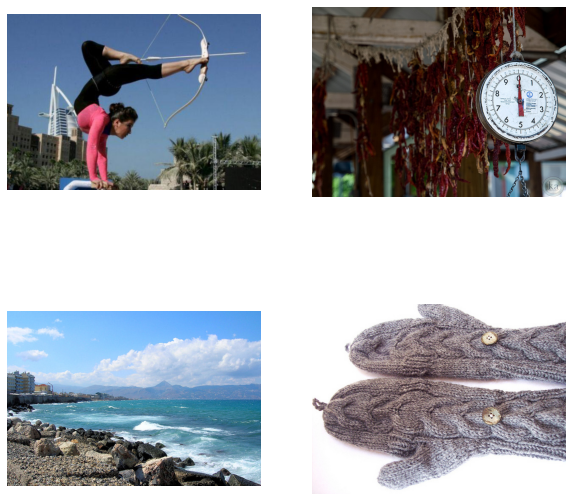

In [7]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
for ax, img_path in zip(axes.flatten(), train_img_paths) :
    ax.imshow(Image.open(img_path))
    ax.axis("off")
    ax.yaxis.set_visible(False), ax.xaxis.set_visible(False)

In [8]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [9]:
def preprocess(image):
    with tf.name_scope('preprocess'):
        # [0, 1] => [-1, 1]
        return image * 2 - 1

def deprocess(image):
    with tf.name_scope('deprocess'):
        # [-1, 1] => [0, 1]
        return (image + 1) / 2

def preprocess_lab(lab):
    with tf.name_scope('preprocess_lab'):
        L_chan, a_chan, b_chan = tf.unstack(lab, axis=2)
        # L_chan: black and white with input range [0, 100]
        # a_chan/b_chan: color channels with input range ~[-110, 110], not exact
        # [0, 100] => [-1, 1],  ~[-110, 110] => [-1, 1]
        return [L_chan / 50 - 1, a_chan / 110, b_chan / 110]

def deprocess_lab(L_chan, a_chan, b_chan):
    with tf.name_scope('deprocess_lab'):
        #TODO This is axis=3 instead of axis=2 when deprocessing batch of images 
               # ( we process individual images but deprocess batches)
        #return tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=3)
        return tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=2)

def augment(image, brightness):
    # (a, b) color channels, combine with L channel and convert to rgb
    a_chan, b_chan = tf.unstack(image, axis=3)
    L_chan = tf.squeeze(brightness, axis=3)
    lab = deprocess_lab(L_chan, a_chan, b_chan)
    rgb = lab_to_rgb(lab)
    return rgb

def check_image(image):
    assertion = tf.assert_equal(tf.shape(image)[-1], 3, message='image must have 3 color channels')
    with tf.control_dependencies([assertion]):
        image = tf.identity(image)

    if image.get_shape().ndims not in (3, 4):
        raise ValueError('image must be either 3 or 4 dimensions')

    # make the last dimension 3 so that you can unstack the colors
    shape = list(image.get_shape())
    shape[-1] = 3
    image.set_shape(shape)
    return image

def rgb_to_lab(srgb):
    # based on https://github.com/torch/image/blob/9f65c30167b2048ecbe8b7befdc6b2d6d12baee9/generic/image.c
    with tf.name_scope('rgb_to_lab'):
        srgb = check_image(srgb)
        srgb_pixels = tf.reshape(srgb, [-1, 3])
        with tf.name_scope('srgb_to_xyz'):
            linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
            exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
            rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
            rgb_to_xyz = tf.constant([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334], # R
                [0.357580, 0.715160, 0.119193], # G
                [0.180423, 0.072169, 0.950227], # B
            ])
            xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope('xyz_to_cielab'):
            # convert to fx = f(X/Xn), fy = f(Y/Yn), fz = f(Z/Zn)

            # normalize for D65 white point
            xyz_normalized_pixels = tf.multiply(xyz_pixels, [1/0.950456, 1.0, 1/1.088754])

            epsilon = 6/29
            linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
            exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
            fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4/29) * linear_mask + (xyz_normalized_pixels ** (1/3)) * exponential_mask

            # convert to lab
            fxfyfz_to_lab = tf.constant([
                #  l       a       b
                [  0.0,  500.0,    0.0], # fx
                [116.0, -500.0,  200.0], # fy
                [  0.0,    0.0, -200.0], # fz
            ])
            lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])

        return tf.reshape(lab_pixels, tf.shape(srgb))


def lab_to_rgb(lab):
    with tf.name_scope('lab_to_rgb'):
        lab = check_image(lab)
        lab_pixels = tf.reshape(lab, [-1, 3])
        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope('cielab_to_xyz'):
            # convert to fxfyfz
            lab_to_fxfyfz = tf.constant([
                #   fx      fy        fz
                [1/116.0, 1/116.0,  1/116.0], # l
                [1/500.0,     0.0,      0.0], # a
                [    0.0,     0.0, -1/200.0], # b
            ])
            fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

            # convert to xyz
            epsilon = 6/29
            linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
            exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
            xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

            # denormalize for D65 white point
            xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

        with tf.name_scope('xyz_to_srgb'):
            xyz_to_rgb = tf.constant([
                #     r           g          b
                [ 3.2404542, -0.9692660,  0.0556434], # x
                [-1.5371385,  1.8760108, -0.2040259], # y
                [-0.4985314,  0.0415560,  1.0572252], # z
            ])
            rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
            # avoid a slightly negative number messing up the conversion
            rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
            linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
            exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
            srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1/2.4) * 1.055) - 0.055) * exponential_mask

        return tf.reshape(srgb_pixels, tf.shape(lab))

In [10]:
def resize(image, height, width) :
    reimage = tf.image.resize(image, [height, width], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return reimage

def flip(input_image) :
    image = input_image
    if tf.random.uniform(()) > 0.5 :
        image = tf.image.flip_left_right(input_image)
    return image
def load(img):
    img = rgb2lab(img)
    return img

In [11]:
def load_train_image(img_file) :
    image = tf.io.read_file(img_file)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = resize(image, IMG_HEIGHT, IMG_WIDTH)
    image = flip(image)
    image = tf.cast(image, tf.float32)
    
    # lab = tf.py_function(func = load, inp = [image], Tout = tf.float32)
    lab = rgb_to_lab(image)
    L_chan, a_chan, b_chan = preprocess_lab(lab)
    lab = deprocess_lab(L_chan, a_chan, b_chan)
    # image = tf.cast(image, tf.uint8)
    L_ = lab[:, :, 0:1]
    ab_ = lab[:, :, 1:]

    return L_, ab_

def load_val_image(img_file) :
    image = tf.io.read_file(img_file)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = resize(image, IMG_HEIGHT, IMG_WIDTH)
    image = tf.cast(image, tf.float32)
    # lab = tf.py_function(func = load, inp = [image], Tout = tf.float32)
    lab = rgb_to_lab(image)
    L_chan, a_chan, b_chan = preprocess_lab(lab)
    lab = deprocess_lab(L_chan, a_chan, b_chan)
    
    # tf.cast(image, tf.uint8)
    L_ = lab[:, :, 0:1]
    ab_ = lab[:, :, 1:3]

    return L_, ab_


In [12]:
train_images = []
val_images = []
for img_path in train_img_paths:
    im = Image.open(img_path)
    train_images.append(im)

for val_path in val_img_paths:
    im = Image.open(img_path)
    val_images.append(im)


def generate_dataset(images):
    X = []
    Y = []
    for i in images:
        i = resize(i, IMG_HEIGHT, IMG_WIDTH)
        lab_img = lab2rgb(i / 255)
        x = lab_img[:, :, 0]
        y = lab_img[:, :, 1:]
        X.append(x.reshape(256, 256, 1))
        Y.append(y)
    X = np.array(x, dtype = np.float32)
    Y = np.array(y, dtype = np.float32)
    return X, Y

X_train, Y_train = generate_images(train_images)
X_test, Y_test = generate_images(val_images)


NameError: ignored

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [ ]:
OUTPUT_CHANELS = 2

**UNeT**

In [ ]:
def downsample(filter, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(keras.layers.Conv2D(filter, size, padding = 'same',
                                   strides = 2, kernel_initializer = initializer,
                                   use_bias = False))
    if apply_batchnorm :
        result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.Dropout(rate = 0.5))
    result.add(keras.layers.LeakyReLU())
    return result

In [ ]:
def upsample(filter, size, apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filter, size, padding = 'same',
                                            strides = 2, kernel_initializer= initializer,
                                            use_bias = False))
    result.add(keras.layers.BatchNormalization())
    if apply_dropout :
        result.add(keras.layers.Dropout(rate = 0.5))
    result.add(keras.layers.ReLU())
    return result

In [ ]:
def Generator():
    inputs = keras.layers.Input(shape = [IMG_HEIGHT, IMG_WIDTH, 1])
    
    #bs == batch_size
    
    encoder = [
        downsample(64, 4, False), #[bs, 128, 128, 64]
        downsample(128, 4),       #[bs, 64, 64, 128]    
        downsample(256, 4),       #[bs, 32, 32, 256]
        downsample(512, 4),       #[bs, 16, 16, 512] 
        downsample(512, 4),       #[bs, 8, 8, 512]
        downsample(512, 4),       #[bs, 4, 4, 512]    
        downsample(512, 4),       #[bs, 2, 2, 512]
        downsample(512, 4)         #[bs, 1, 1, 512]
    ]
    
    decoder = [
        upsample(512, 4, True), #[bs, 2, 2, 512 * 2]
        upsample(512, 4, True), #[bs, 4, 4, 512 * 2]
        upsample(512, 4, True), #[bs, 8, 8, 512 * 2]
        upsample(512, 4),        #[bs, 16, 16, 512 * 2]    
        upsample(256, 4),        #[bs, 32, 32, 256 * 2] 
        upsample(128, 4),        #[bs, 64, 64, 128 * 2]
        upsample(64, 4)          #[bs, 128, 128, 64 * 2]  
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    
    last = keras.layers.Conv2DTranspose(OUTPUT_CHANELS, 4, 
                                        strides = 2, padding = 'same', 
                                        kernel_initializer = initializer, activation = 'tanh' )
    
    x = inputs
    skips = []
    for down in encoder :
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(decoder, skips) :
        x = up(x)
        x = keras.layers.Concatenate()([x, skip])
        
    output = last(x)
    
    return keras.Model(inputs = inputs, outputs = output) 

In [ ]:
generator = Generator()
# keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

In [ ]:
LAMDA = 100
BCE_loss = keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = BCE_loss(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = keras.losses.MAE(target, gen_output)
    net_loss = gan_loss + l1_loss
    return net_loss, gan_loss, l1_loss

In [ ]:
def Discriminator() :
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = keras.layers.Input(shape = [IMG_HEIGHT, IMG_WIDTH, 1], name = 'input_image')
    tar = keras.layers.Input(shape = [IMG_HEIGHT, IMG_WIDTH, 3], name = 'target_image')
    
    x  = keras.layers.concatenate([inp, tar])
    x_1 = downsample(64, 4, False)(x)
    x_2 = downsample(128, 4)(x_1)
    x_3 = downsample(256, 4)(x_2)
    
    zero_pad_1 = keras.layers.ZeroPadding2D()(x_3)
    conv_1 = keras.layers.Conv2D(512, 4, kernel_initializer = initializer, use_bias = False)(zero_pad_1)
    batchnorm_1 = keras.layers.BatchNormalization()(conv_1)
    activation_1 = keras.layers.LeakyReLU()(batchnorm_1)
    zero_pad_2 = keras.layers.ZeroPadding2D()(activation_1)
    
    last = keras.layers.Conv2D(1, 4, kernel_initializer = initializer)(zero_pad_2)
    
    return keras.Model(inputs = [inp, tar], outputs = last)   

In [ ]:
discriminator = Discriminator()

In [ ]:
def discriminator_loss(disc_generated_output, disc_real_output):
    real_loss = BCE_loss(tf.ones_like(disc_real_output), disc_real_output)
    gen_loss = BCE_loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    net_loss = gen_loss + real_loss
    return net_loss

In [ ]:
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [ ]:
# Training Checkpoint
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, 
                                 discriminator_optimizer = discriminator_optimizer, 
                                 generator = generator, discriminator = discriminator
                                )



In [ ]:
EPOCHS = 5

In [ ]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function

def train_step(input_image, target, epoch) :
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape :
        gen_output = generator(input_image, training = True)
        
        fake_image = tf.concat([input_image, gen_output], axis = -1)
        real_image = tf.concat([input_image, target], axis = -1)
        
        disc_real_output = discriminator([input_image, real_image], training = True)
        disc_generated_output = discriminator([input_image, fake_image], training = True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_grads = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
        

    
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [ ]:
def fit(train_ds, val_ds, epochs):
    for epoch in range(epochs) :
        print("\nEpoch {}/{}".format(epoch + 1,epochs))
        start = time.time()
        
        num_training_samples = len(train_img_paths)

        pb_i = Progbar(num_training_samples)
        
        ii = 0
        for n, (train_input, train_target) in train_ds.enumerate():
            gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(train_input, train_target, epoch)
            vals = [('gen_loss', gen_total_loss), ('gen_gan_loss', gen_gan_loss), ('gen_l1_loss', gen_l1_loss), ('disc_loss', disc_loss)]
            pb_i.update(ii * BATCH_SIZE, values = vals)
            ii = ii + 1 

    if (epoch + 1) % 20 == 0 :
        checkpoint.save(file_prefix = checkpoint_prefix)
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
import gc
gc.collect()

In [ ]:
with tf.device(device_name) :
    fit(train_dataset, val_dataset, EPOCHS)

In [ ]:
Y_hat = generator(X_test[:25])
total_count = len(Y_hat)

for idx, (x, y, y_hat) in enumerate(zip(X_test[:25], Y_test[:25], Y_hat)):

    # Original RGB image
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Grayscale version of the original image
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Colorized image
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)


    
    plt.axis('off')
    plt.imshow(grayscale_rgb)
    # plt.savefig(os.path.join(WORKDIR, 'results', '{}-bw.png'.format(idx)), dpi=1)

    plt.axis('off')
    plt.imshow(orig_rgb)
    # plt.savefig(os.path.join(WORKDIR, 'results', '{}-gt.png'.format(idx)), dpi=1)

    plt.axis('off')
    plt.imshow(predicted_rgb)
    # plt.savefig(os.path.join(WORKDIR, 'results', '{}-gan.png'.format(idx)), dpi=1)

    sys.stdout.flush()
    # sys.stdout.write('\r{} / {}'.format(idx + 1, total_count))